# 向量空间模型

In [241]:
import re
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
from d2l import torch as d2l
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

texts = [
    "I am happy.",
    "You are happy.",
    "I am you"
]

In [219]:
df_train = pd.read_csv('new_train.tsv', header=0, sep='\t')
train_texts = list(np.array(df_train)[:, 0])
df_test = pd.read_csv('new_test.tsv', header=0, sep='\t')
test_texts = list(np.array(df_test)[:, 0])

In [230]:
class Bag:
    def __init__(self, *args):
        self.__texts = []
        self.__len = -1
        self.__value = {}
        for texts in args:
            for text in texts:
                words = re.split(r'\W+', text.lower())
                self.__texts.append(words)
                for word in words:
                    if word not in self.__value and len(word) > 0:
                        self.__len += 1
                        self.__value[word] = self.__len


    def inquiry(self, word):
        if word not in self.__value:
            pass
        else:
            return self.__value[word]

    def len(self):
        return self.__len

    def __str__(self):
        return f"<Bag> value: {str(self.__value)}; length: {str(self.__len)}"

    def value(self):
        return self.__value


In [231]:
def word2vec(word, bag):
    dimension = bag.len()+1
    vec = torch.zeros(dimension)
    vec[bag.inquiry(word)] = 1
    return vec


In [232]:
class Query:
    def __init__(self, word, vec):
        self.__word = word
        self.__vec = vec

    def __repr__(self):
        return f"<Query> word: {self.__word}; vec: {self.__vec}"

    def word(self):
        return self.__word

    def vec(self):
        return self.__vec

In [233]:
class Document:
    def __init__(self, text, bag):
        self.__text = text
        self.__queries = []
        self.__bag = bag
        for word in self.__text:
            if len(word) > 0:
                # print(word)
                self.__queries.append(Query(word, word2vec(word, bag)))
        self.__init_tf()
        self.__vector = torch.zeros(self.__bag.len()+1)


    def __repr__(self):
        return f"<Document> text: {self.__text}; queries: {self.__queries}"

    def __init_tf(self):
        text_length = len(self.__queries)
        bag_length = self.__bag.len()
        frequency = torch.zeros(bag_length+1)

        # self.__tf = torch.cat([torch.zeros([1,bag_length+1]), torch.arange(0,bag_length+1,1).reshape(1,-1)],0).t()

        # print(self.__queries)

        for query in self.__queries:
            word = query.word()
            key = self.__bag.inquiry(word)
            # self.__tf[key][0] += 1.0
            frequency[key] += 1
        self.__tf = frequency/text_length
        # print(f"<tf> {self.__tf}")

    def queries(self):
        return self.__queries

    def tf(self):
        return self.__tf

    def assign_vector(self, value):
        self.__vector = value

    def vector(self):
        return self.__vector

In [234]:
class Documents:
    def __init__(self, doc_texts, bag):
        self.__texts = doc_texts
        self.__bag = bag
        self.__value = []
        self.__init_idf()


    def init_doc_from_a2b(self, a, b):
        for text in self.__texts[a:b]:
            self.__value.append(Document(re.split(r'\W+', text.lower()), self.__bag))
        # self.__init_idf()
        return self.__init_vector()

    def init_doc_with_id(self, id):
        self.__value.append(Document(re.split(r'\W+', self.__texts[id].lower()), self.__bag))
        self.__assign_vector(id)

    def __str__(self):
        return f"<Documents>\nbag: {str(self.__bag)}; value: {str(self.__value)}"

    def __getitem__(self, index):
        return self.__value[index]

    def __init_idf(self):
        doc_length = len(self.__texts)
        bag_length = self.__bag.len()
        frequency = torch.zeros(bag_length+1)
        for text in self.__texts:
            # print(text)
            temp_doc = Document(re.split(r'\W+', text.lower()), self.__bag)
            for query in temp_doc.queries():
                vec = query.vec()
                # print(vec)
                frequency = vec + frequency
            del temp_doc
        self.__idf = torch.log(doc_length/(frequency+1))
        print(f"<idf> {self.__idf}")
        print(f"mean: {torch.mean(self.__idf)}")
        print(f"min: {torch.min(self.__idf)}")
        print(f"max: {torch.max(self.__idf)}")
        print(f"quantile: {torch.quantile(self.__idf, torch.tensor([0.1, 0.5, 0.9]))}")

    def idf(self):
        return self.__idf

    def __init_vector(self):
        length = len(self.__value)
        vectors = torch.zeros(len(self.__value),self.__bag.len()+1)
        for id in range(length):
            doc = self.__value[id]
            vector = torch.zeros(self.__bag.len()+1)
            vector = torch.mul(self.__idf, doc.tf())
            doc.assign_vector(vector)
            vectors[id] = vector
        return vectors

    def bag_length(self):
        return self.__bag.len()

    def __assign_vector(self, i):
        doc = self.__value[i]
        vector = torch.zeros(self.__bag.len()+1)
        vector = torch.mul(self.__idf, doc.tf())
        doc.assign_vector(vector)

    def value(self):
        return self.__value

    def get_vector(self, index):
        self.__value.append(Document(re.split(r'\W+', self.__texts[index].lower()), self.__bag))
        self.__assign_vector(-1)
        vector = self.__value[-1].vector()
        del self.__value[-1]
        return vector


In [235]:
bag = Bag(train_texts, test_texts)
documents = Documents(doc_texts=train_texts, bag=bag)
documents.bag_length()

<idf> tensor([3.4865, 5.0437, 0.6589,  ..., 9.0510, 9.0510, 9.0510])
mean: 7.9194769859313965
min: 0.15563727915287018
max: 9.050992965698242
quantile: tensor([6.7484, 8.3578, 9.0510])


17703

X = documents.init_doc_from_a2b(0, L)
X

In [278]:
net = nn.Sequential(nn.Linear(documents.bag_length()+1, 256),
                    nn.ReLU(),
                    nn.Linear(256, 5),)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [273]:
batch_size, lr, num_epochs = 256, 0.2, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [274]:
class MyDataset(Dataset):
     def __init__(self, y, docs):
         super(Dataset, self).__init__()
         self.__documents = docs
         self.__Y = y
     def __len__(self):
         return len(self.__Y)

     def __getitem__(self, index):
         return self.__documents.get_vector(index),self.__Y[index]

Y = torch.tensor(list(np.array(df_train)[:, 1]))
data_train = MyDataset(Y, documents)
train_iter = DataLoader(data_train, batch_size, shuffle=True)
for batch_idx, samples in enumerate(train_iter):
    print(batch_idx,samples[0].shape)

0 torch.Size([256, 17704])
1 torch.Size([256, 17704])
2 torch.Size([256, 17704])
3 torch.Size([256, 17704])
4 torch.Size([256, 17704])
5 torch.Size([256, 17704])
6 torch.Size([256, 17704])
7 torch.Size([256, 17704])
8 torch.Size([256, 17704])
9 torch.Size([256, 17704])
10 torch.Size([256, 17704])
11 torch.Size([256, 17704])
12 torch.Size([256, 17704])
13 torch.Size([256, 17704])
14 torch.Size([256, 17704])
15 torch.Size([256, 17704])
16 torch.Size([256, 17704])
17 torch.Size([256, 17704])
18 torch.Size([256, 17704])
19 torch.Size([256, 17704])
20 torch.Size([256, 17704])
21 torch.Size([256, 17704])
22 torch.Size([256, 17704])
23 torch.Size([256, 17704])
24 torch.Size([256, 17704])
25 torch.Size([256, 17704])
26 torch.Size([256, 17704])
27 torch.Size([256, 17704])
28 torch.Size([256, 17704])
29 torch.Size([256, 17704])
30 torch.Size([256, 17704])
31 torch.Size([256, 17704])
32 torch.Size([256, 17704])
33 torch.Size([79, 17704])


In [275]:
data_test = MyDataset(torch.tensor(list(np.array(df_test)[:, 1])), Documents(doc_texts=test_texts, bag=bag))
test_iter = DataLoader(data_test, batch_size, shuffle=True)

<idf> tensor([3.2599, 4.8460, 0.6722,  ..., 7.4110, 7.4110, 7.4110])
mean: 7.480660915374756
min: 0.14902478456497192
max: 8.10409927368164
quantile: tensor([6.4947, 7.4110, 8.1041])


In [276]:
# define draw
def plotCurve(x_vals, y_vals,
                x_label, y_label,
                x2_vals=None, y2_vals=None,
                legend=None,
                figsize=(3.5, 2.5)):
    # set figsize
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')

    if legend:
        plt.legend(legend)

training on cpu
Epoch 1: Train Loss 13664.8306, Train Acc 0.2944, Test Loss 5301.3730, Test Acc 0.3008
Epoch 2: Train Loss 13664.8305, Train Acc 0.2944, Test Loss 5301.3731, Test Acc 0.3008
Epoch 3: Train Loss 13664.8308, Train Acc 0.2944, Test Loss 5301.3729, Test Acc 0.3008
Epoch 4: Train Loss 13664.8306, Train Acc 0.2944, Test Loss 5301.3730, Test Acc 0.3008
Epoch 5: Train Loss 13664.8307, Train Acc 0.2944, Test Loss 5301.3730, Test Acc 0.3008
Epoch 6: Train Loss 13664.8307, Train Acc 0.2944, Test Loss 5301.3730, Test Acc 0.3008
Epoch 7: Train Loss 13664.8306, Train Acc 0.2944, Test Loss 5301.3730, Test Acc 0.3008
Epoch 8: Train Loss 13664.8306, Train Acc 0.2944, Test Loss 5301.3730, Test Acc 0.3008
Epoch 9: Train Loss 13664.8306, Train Acc 0.2944, Test Loss 5301.3730, Test Acc 0.3008
Epoch 10: Train Loss 13664.8308, Train Acc 0.2944, Test Loss 5301.3731, Test Acc 0.3008


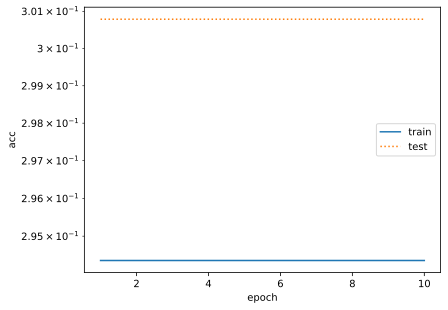

In [279]:
def train(net, train_iter, test_iter, loss, num_epochs, trainer, device=torch.device('cpu')):
    net.to(device)  # 把模型放到 GPU（如果可用）
    print("training on", device)

    train_ls , test_ls = [], []

    for epoch in range(num_epochs):
        net.train()  # 训练模式
        train_loss, train_correct, train_samples = 0, 0, 0

        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)  # 计算损失

            trainer.zero_grad()  # 清空梯度
            l.mean().backward()  # 反向传播
            trainer.step()  # 更新参数

            train_loss += l.sum().item()  # 累计损失
            train_correct += (y_hat.argmax(dim=1) == y).sum().item()  # 统计正确数
            train_samples += y.shape[0]

        train_acc = train_correct / train_samples  # 计算训练准确率


        # 评估阶段（不计算梯度）
        net.eval()  # 设为评估模式（禁用 dropout/batchnorm）
        test_loss, test_correct, test_samples = 0, 0, 0

        with torch.no_grad():  # 禁用梯度计算，提高推理速度
            for X, y in test_iter:
                X, y = X.to(device), y.to(device)
                y_hat = net(X)
                test_loss += loss(y_hat, y).sum().item()
                test_correct += (y_hat.argmax(dim=1) == y).sum().item()
                test_samples += y.shape[0]

        test_acc = test_correct / test_samples  # 计算测试准确率

        train_ls.append(train_acc)
        test_ls.append(test_acc)

        # 打印训练 & 测试结果
        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
              f"Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")


    plotCurve(range(1, num_epochs + 1), train_ls,
              "epoch", "acc",
              range(1, num_epochs + 1), test_ls,
              ["train", "test"])

# 运行训练循环
train(net, train_iter, test_iter, loss, num_epochs, trainer)



## batch_size, lr, num_epochs = 256, 0.1, 10

```text
training on cpu
Epoch 1: Loss 12987.1523, Accuracy 0.2992
Epoch 2: Loss 12886.8466, Accuracy 0.2995
Epoch 3: Loss 12852.4375, Accuracy 0.2992
Epoch 4: Loss 12838.6850, Accuracy 0.3002
Epoch 5: Loss 12831.7347, Accuracy 0.2992
Epoch 6: Loss 12827.8995, Accuracy 0.3003
Epoch 7: Loss 12826.1151, Accuracy 0.3010
Epoch 8: Loss 12824.8745, Accuracy 0.3034
Epoch 9: Loss 12823.6724, Accuracy 0.2992
Epoch 10: Loss 12822.8669, Accuracy 0.3014
```

## batch_size, lr, num_epochs = 256, 0.5, 10

```text
training on cpu
Epoch 1: Loss 12825.2286, Accuracy 0.3081
Epoch 2: Loss 12821.7119, Accuracy 0.3103
Epoch 3: Loss 12819.0376, Accuracy 0.3003
Epoch 4: Loss 12814.0477, Accuracy 0.3192
Epoch 5: Loss 12803.9242, Accuracy 0.3193
Epoch 6: Loss 12794.5381, Accuracy 0.3234
Epoch 7: Loss 12774.9155, Accuracy 0.3383
Epoch 8: Loss 12748.2485, Accuracy 0.3836
Epoch 9: Loss 12706.7033, Accuracy 0.3817
Epoch 10: Loss 12640.8037, Accuracy 0.4071
```

## batch_size, lr, num_epochs = 256, 0.5, 10

```text
training on cpu
Epoch 1: Loss 12548.0105, Accuracy 0.4445
Epoch 2: Loss 12429.4254, Accuracy 0.4399
Epoch 3: Loss 12264.4489, Accuracy 0.4467
Epoch 4: Loss 12034.5601, Accuracy 0.4673
Epoch 5: Loss 11819.4379, Accuracy 0.4645
Epoch 6: Loss 11616.8942, Accuracy 0.4474
Epoch 7: Loss 11363.7534, Accuracy 0.4526
Epoch 8: Loss 11203.7427, Accuracy 0.4548
Epoch 9: Loss 11379.9377, Accuracy 0.3997
Epoch 10: Loss 11009.7984, Accuracy 0.4250
Epoch 11: Loss 10640.3052, Accuracy 0.4561
Epoch 12: Loss 10498.5441, Accuracy 0.4617
Epoch 13: Loss 10048.4591, Accuracy 0.5060
Epoch 14: Loss 10184.2839, Accuracy 0.4801
Epoch 15: Loss 9648.3446, Accuracy 0.5150
Epoch 16: Loss 9135.5362, Accuracy 0.5846
Epoch 17: Loss 9343.0057, Accuracy 0.5522
Epoch 18: Loss 9188.6095, Accuracy 0.5447
Epoch 19: Loss 8977.1439, Accuracy 0.5588
Epoch 20: Loss 8420.5632, Accuracy 0.6081
Epoch 21: Loss 8490.2630, Accuracy 0.5899
Epoch 22: Loss 8062.2673, Accuracy 0.6199
Epoch 23: Loss 7744.1738, Accuracy 0.6537
Epoch 24: Loss 7895.3377, Accuracy 0.6200
Epoch 25: Loss 7841.7385, Accuracy 0.6326
Epoch 26: Loss 7254.8940, Accuracy 0.6700
Epoch 27: Loss 7331.7382, Accuracy 0.6695
Epoch 28: Loss 7431.7336, Accuracy 0.6572
Epoch 29: Loss 7040.0912, Accuracy 0.6920
Epoch 30: Loss 6723.7996, Accuracy 0.6835
Epoch 31: Loss 6926.3133, Accuracy 0.6883
Epoch 32: Loss 6527.7595, Accuracy 0.7021
Epoch 33: Loss 5844.5896, Accuracy 0.7434
Epoch 34: Loss 6800.1134, Accuracy 0.6926
Epoch 35: Loss 5941.9769, Accuracy 0.7282
Epoch 36: Loss 6107.0857, Accuracy 0.7345
Epoch 37: Loss 6369.5926, Accuracy 0.7106
Epoch 38: Loss 5879.8370, Accuracy 0.7401
Epoch 39: Loss 5657.3420, Accuracy 0.7615
Epoch 40: Loss 5766.9596, Accuracy 0.7599
Epoch 41: Loss 5850.0123, Accuracy 0.7402
Epoch 42: Loss 5159.7880, Accuracy 0.7792
Epoch 43: Loss 5498.7687, Accuracy 0.7474
Epoch 44: Loss 5519.2371, Accuracy 0.7685
Epoch 45: Loss 5193.5380, Accuracy 0.7611
Epoch 46: Loss 4683.3619, Accuracy 0.7976
Epoch 47: Loss 5162.0233, Accuracy 0.7890
Epoch 48: Loss 4415.0576, Accuracy 0.8120
Epoch 49: Loss 4922.3352, Accuracy 0.7920
Epoch 50: Loss 4507.6059, Accuracy 0.8138
```